The question we're trying to answer is whether the first child is always delayed compared to its due date. I'm doing this retrospectively as a dad but heh - let's see whether this old adage is backed up by science!

## Dataset

We will be leveraging the National Survey of Family Growth - Cycle 6 (2002) available on the [Center for Disease Control and Prevention's website](https://www.cdc.gov/nchs/nsfg/nsfg_cycle6.htm). It contains a wealth of information regarding women and pregnancies.

For this we will be looking `2002FemPreg.dat` file available from the above. Meanings for each of the columns/values is described in the [codebook](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Pregnancy.pdf).

### Parsing

The `dat` file is a fixed-width file. In order to make sense of this we need to know how large each field is and what it represents. We'll take a stab at parsing this using the associated [STATA dictionary](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2002FemPreg.dct). 

#### DAT
```
           1 1     6 1     11093 1084     9 039 9   0  1 813             1093 13837                        1                5                                                                        116610931166 9201093                111             3    1   12  11         5391 110933316108432411211     2995 1212 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231
           1 2     6 1     11166 1157     9 039 9   0  2 714             1166  6542112  2  05 1 4  5       51               1   41  4  201 20                                                        1166109311661093116611661231        111             3    1   14  11         5391 211663925115738501211 2 432 8701414 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231
           ...
```

#### DCT 
```
infile dictionary {
    _column(1)      str12                             caseid  %12s  "RESPONDENT ID NUMBER"
   _column(13)       byte                           pregordr   %2f  "PREGNANCY ORDER (NUMBER)"
   _column(15)       byte                          howpreg_n   %2f  "BB-2 # OF WEEKS OR MONTHS CURRENTLY PREGNANT"
   _column(17)       byte                          howpreg_p   %1f  "BB-2 CURRENT PREGNANCY LENGTH REPORTED IN MONTHS OR WEEKS"
...
```

We want to extract the 3rd and 4th column - the 3rd giving us the column name and the 4th the size of the input (which essentially tells us the number of characters).

In [20]:
with open(r'2002FemPreg.dct') as f:
    infile = f.readline()
    col_dat = []
    for line in f.readlines():
        d = line.split()
        if d[0].startswith('_column'):
            col_dat.append((d[2],int(d[3][1:-1]))) # we want the name and the numerical portion of the format string
print(col_dat[:5])

[('caseid', 12), ('pregordr', 2), ('howpreg_n', 2), ('howpreg_p', 1), ('moscurrp', 1)]


`pandas` has a `read_fwf` method which we will leverage. It needs a list of widths and names for each column.

In [22]:
import pandas as pd
df = pd.read_fwf(r'2002FemPreg.dat', widths=[w for n,w in col_dat], names=[n for n,w in col_dat])

In [23]:
df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,poverty_i,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231


### Data selection

We'll filter on the below and reference the codebook for:
   * Single pregnancy (twins or more will be ignored)
   * Live birth
   * First successful pregnancy
   
Unfortunately we can't tell which were induced/elective c-section (some parents do like to choose when their children will be born - certainly in Asia), but that should hopefully be a small percentage.

In [41]:
import numpy as np
# filter on 1st, live, single births
fdf = df[df['pregend1'].isin([5,6]) & ((df['multbrth'] == 5) | df['multbrth'].isnull()) & (df['birthord'] == 1)]
len(fdf)

4368

So we have 4368 data points. Let's find out what the gestation period of those babies were and display that in a histogram. But first we need to clean the data up (again...). We're excluding any NaN and gestation period outside of the [20,54] weeks range.

4347
39.0    2143
40.0     535
41.0     360
38.0     248
42.0     207
37.0     205
36.0     169
35.0     119
43.0      88
30.0      64
32.0      54
34.0      26
44.0      23
28.0      22
33.0      22
26.0      17
31.0      13
24.0       7
29.0       7
45.0       6
48.0       3
22.0       2
46.0       2
47.0       1
25.0       1
27.0       1
21.0       1
23.0       1
Name: wksgest, dtype: int64


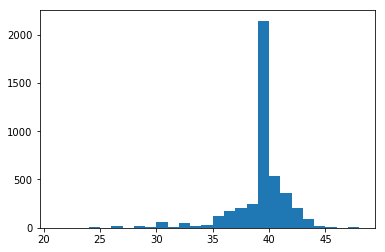

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
data = fdf.wksgest[(fdf.wksgest > 20) & (fdf.wksgest < 54)]
data.dropna()
print(len(data))
numbins = int(max(data)-min(data))
plt.hist(data, bins=numbins)
print(data.value_counts())

We clearly see the vast majority of births ar at the 39th week - and that those have more of tendency to be late than early (the number of births in the 40 and 41 weeks buckets are 4 times those in the 38 bucket).

Now the question remains, how does that compare to a second, third or 4th child?